In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Data Preparation

## Adding noise
Let's define a function that takes an image and applies noise with a given noise factor.
Later we'll use this function to apply it to our datasets via .map() function.

In [2]:
def add_noise(img, noise_factor):
    # create a random tensor and add to the image with a given noise factor
    img = img + tf.random.normal(shape=img.shape) * noise_factor
    # clip values, so we don't go above 1.0
    img = tf.clip_by_value(img, clip_value_min=0., clip_value_max=1.)

    return img


We drop the labels since we don't need them. We also do the regular preparation steps here, like shuffle, batch etc.
Since last layer is sigmoid, we normalize image values to be between 0 and 1.

In [3]:
def prepare_data(ds, batch_size, noise_factor):
    # drop labels, cast & normalize image data to between 0 and 1
    ds = ds.map(lambda img, target: tf.cast(img, tf.float32) / 255.)
    # add noise to images and map to a tuple of (noised, original)
    ds = ds.map(lambda img: (add_noise(img, noise_factor), img))

    return ds.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Define hyperparameters

In [4]:
batch_size = 16
learning_rate = 0.001
noise_factor = 0.2
num_epochs = 10

## Apply noise and preparation steps to MNIST datasets

In [5]:
# Generate train & test datasets
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
noisy_train_ds = prepare_data(train_ds, batch_size, noise_factor)
noisy_test_ds = prepare_data(test_ds, batch_size, noise_factor)

Metal device set to: Apple M1 Pro


2023-01-06 19:35:24.617026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-06 19:35:24.618013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Visualization before training
We first define a function that we'll use to visualize our data.
The function will allow us to plot _n_ images from multiple datasets.
Each dataset will be displayed on a separate row.

In [14]:
def plot_examples(data_dict, n):
    """
    Plots a given number of images for each dataset in the dictionary.
    It takes `n` examples from each dataset and displays them on separate rows.
    Each row will have n elements from the corresponding dataset.
    :param data_dict: titles and datasets to be plotted.
        should have the type {"title1": dataset1, "title2": dataset2...}
    :param n: number of examples, which corresponds to number of examples from each dataset
    """
    rows = len(data_dict)
    plt.figure()
    for i in range(n):
        for j, (title, data) in enumerate(data_dict.items()):
            ax = plt.subplot(rows, n, (j * n) + i + 1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.gray()
            plt.title(title)
            plt.imshow(data[i])
    plt.show()

Let's plot 5 noisy images that we generated, with their originals on a separate row

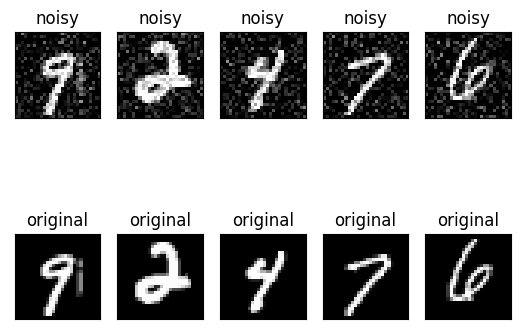

In [15]:
# Show noisy and original examples
for noisy, orig in noisy_train_ds.take(1):
    plot_examples({"noisy": noisy, "original": orig}, n=5)

# Convolutional Encoder
Let's define the encoder model that we will use for our autoencoder.
We'll have 2 convolutional layers that will bring the 28x28x1 MNIST image down to first
14x14, then to 7x7.
Then we use a Flatten layer to turn this into a vector of size 49.
Finally, we have an output layer that will define our embedding, with the given embedding size.

In [8]:
class ConvolutionalEncoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                            strides=2, input_shape=(28, 28, 1))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                            strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(embedding_size)

    def call(self, x, **kwargs):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x


# Convolutional Decoder
And now we define the decoder model that we'll use as part of our autoencoder.
This decoder will take the embedding vector, increase it to a vector of size 49, which we
reshape again into 7x7.
Then we apply Conv2DTranspose layers to scale it up to first 14x14, then to 28x28.
Finally we have a single Conv2D layer with a single filter and sigmoid activation,
that will output our final image.

In [9]:
class ConvolutionalDecoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()
        self.dense = tf.keras.layers.Dense(7 * 7, activation='relu', input_shape=(embedding_size,))
        self.reshape = tf.keras.layers.Reshape(target_shape=(7, 7, 1))

        self.transpose1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2,
                                                          padding='same')
        self.transpose2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2,
                                                          padding='same')
        self.output_conv = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation='sigmoid', padding='same')

    def call(self, x, **kwargs):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.transpose1(x)
        x = self.transpose2(x)
        x = self.output_conv(x)

        return x

# Autoencoder model
We define our autoencoder model with a given embedding size, which will create appropriate
encoder and decoder models. The input will be first processed by the encoder and its output
will then be processed by the decoder.

In [10]:
class ConvolutionalAutoencoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()

        self.encoder = ConvolutionalEncoder(embedding_size)
        self.decoder = ConvolutionalDecoder(embedding_size)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.MeanAbsoluteError(name="MAE")]

    def call(self, x, **kwargs):
        z = self.encoder(x)
        x_prime = self.decoder(z)

        return x_prime

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def train_step(self, data):
        sequence, label = data
        with tf.GradientTape() as tape:
            output = self(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        sequence, label = data
        output = self(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name: m.result() for m in self.metrics}

# Training
Let's define our embedding size, create an autoencoder instance and start training.

In [11]:
embedding_size = 10

autoencoder = ConvolutionalAutoencoder(embedding_size)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())
history = autoencoder.fit(noisy_train_ds, validation_data=noisy_test_ds, epochs=num_epochs)

Epoch 1/10


2023-01-06 19:36:02.165856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3745/3750 [============================>.] - ETA: 0s - loss: 0.0492 - MAE: 0.1120

2023-01-06 19:36:31.541643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 33s 8ms/step - loss: 0.0492 - MAE: 0.1120 - val_loss: 0.0410 - val_MAE: 0.0958
Epoch 2/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0391 - MAE: 0.0916 - val_loss: 0.0378 - val_MAE: 0.0897
Epoch 3/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0373 - MAE: 0.0876 - val_loss: 0.0365 - val_MAE: 0.0870
Epoch 4/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0363 - MAE: 0.0856 - val_loss: 0.0361 - val_MAE: 0.0842
Epoch 5/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0357 - MAE: 0.0844 - val_loss: 0.0355 - val_MAE: 0.0845
Epoch 6/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0353 - MAE: 0.0835 - val_loss: 0.0353 - val_MAE: 0.0831
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0349 - MAE: 0.0827 - val_loss: 0.0347 - val_MAE: 0.0821
Epoch 8/10
3750/3750 [==============================] - 31s 8ms/st

# Visualization
Let's plot our training and validation losses as usual

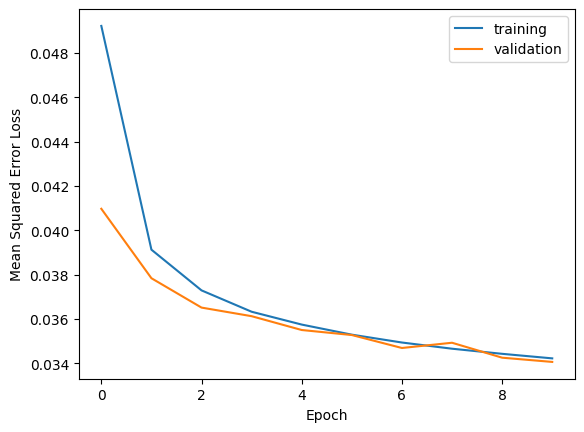

In [12]:
# Plot training and validation losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["training", "validation"])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.show()

## Plotting noised, original and denoised images
Here we use our function from before to plot the images. Now we also show the output of our
autoencoder, which will be the denoised versions.

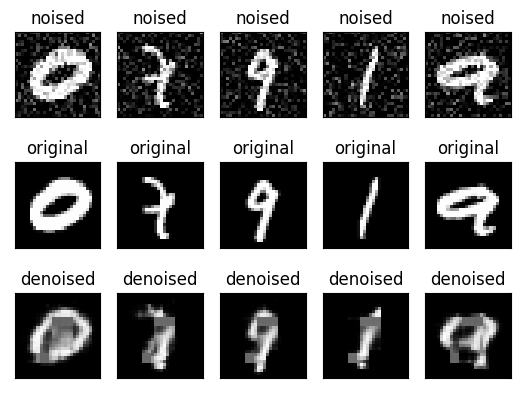

In [16]:
# Denoise some new examples from test dataset, display alongside noised & original versions for comparison
for noisy, orig in noisy_test_ds.take(1):
    decoded = autoencoder(noisy, training=False)
    plot_examples({"noised": noisy, "original": orig, "denoised": decoded}, n=5)